In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
from time import time
from decimal import Decimal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
### import normal tests
tic = time()

for i in range(1, 5):
    signals_file = f"./Training/BUN_normal/ATData/{i}.xlsx"
    n_signals = f"n_signals_{i}"
    
    bubble_detect_file = f"./Training/BUN_normal/BubbleDetectTime/{i}.xlsx"
    n_bubble_detect = f"n_bubble_detect_{i}"
    
    globals()[n_signals] = pd.read_excel(signals_file)
    globals()[n_bubble_detect] = pd.read_excel(bubble_detect_file)

toc = time()
print(f"Done in {toc - tic:.3f}s")

Done in 1168.027s


In [ ]:
### import FG normal tests ONLY
tic = time()

n_signals = pd.read_excel('./Training/FG_normal/FG_normal_ATData.xlsx')
n_bubble_detect = pd.read_excel('./Training/FG_normal/FG_normal_BubbleDetectTime.xlsx')

toc = time()
print(f"Done in {toc - tic:.3f}s")

In [3]:
### concatenating normal tests
n_signals = pd.concat([n_signals_1, n_signals_2, n_signals_3, n_signals_4])
n_bubble_detect = pd.concat([n_bubble_detect_1, n_bubble_detect_2, n_bubble_detect_3, n_bubble_detect_4])

In [4]:
class Test:
    def __init__(self, ID, BubbleDetectTime, P4, P5, A4):
        self.ID = ID
        self.BubbleDetectTime = BubbleDetectTime
        self.P4 = P4 # potassium
        self.P5 = P5 # calcium
        self.A4 = A4 # crea
        
    # function to offset t = 0
    def offset_time(self):
        # using Decimal due to rounding error
        t_0 = Decimal(str(self.BubbleDetectTime + 30))
        t_step = Decimal(str(0.2))
        start_idx = round(t_0/t_step) - 1
                
        self.P4 = self.P4[start_idx:]
        self.P5 = self.P5[start_idx:]
        self.A4 = self.A4[start_idx:]
        
    # function to trim NaNs
    def trim_NaNs(self):
        # making sure list is not empty
        while len(self.P4) > 0 and math.isnan(self.P4[-1]):
            self.P4.pop()
                
        while len(self.P5) > 0 and math.isnan(self.P5[-1]):
            self.P5.pop()
        
        while len(self.A4) > 0 and math.isnan(self.A4[-1]):
            self.A4.pop()

In [5]:
def create_test_list(signals, bubble_detect_time):
    # separating channels
    group_channels = signals.groupby('Channel')
    channel_dfs = {}

    # iterating over the groups and creating a new dataframe for each group
    for channel, group in group_channels:
        df = pd.DataFrame(group.iloc[:, 2:])
        channel_dfs[channel] = df

    # creating test objects
    tests = []
    for i in range(0, len(bubble_detect_time)):
        ID = bubble_detect_time.iloc[i, 0]
        BubbleDetectTime = bubble_detect_time.iloc[i, 1]
        P4 = channel_dfs['P4'].iloc[i, :].values.tolist()
        P5 = channel_dfs['P5'].iloc[i, :].values.tolist()
        A4 = channel_dfs['A4'].iloc[i, :].values.tolist()

        new_test = Test(ID, BubbleDetectTime, P4, P5, A4)
        tests.append(new_test)
    
    return tests

In [6]:
### making test objects 
n_tests = create_test_list(n_signals, n_bubble_detect)

### offset and trim all tests
for test in n_tests: 
    test.offset_time()
    test.trim_NaNs()

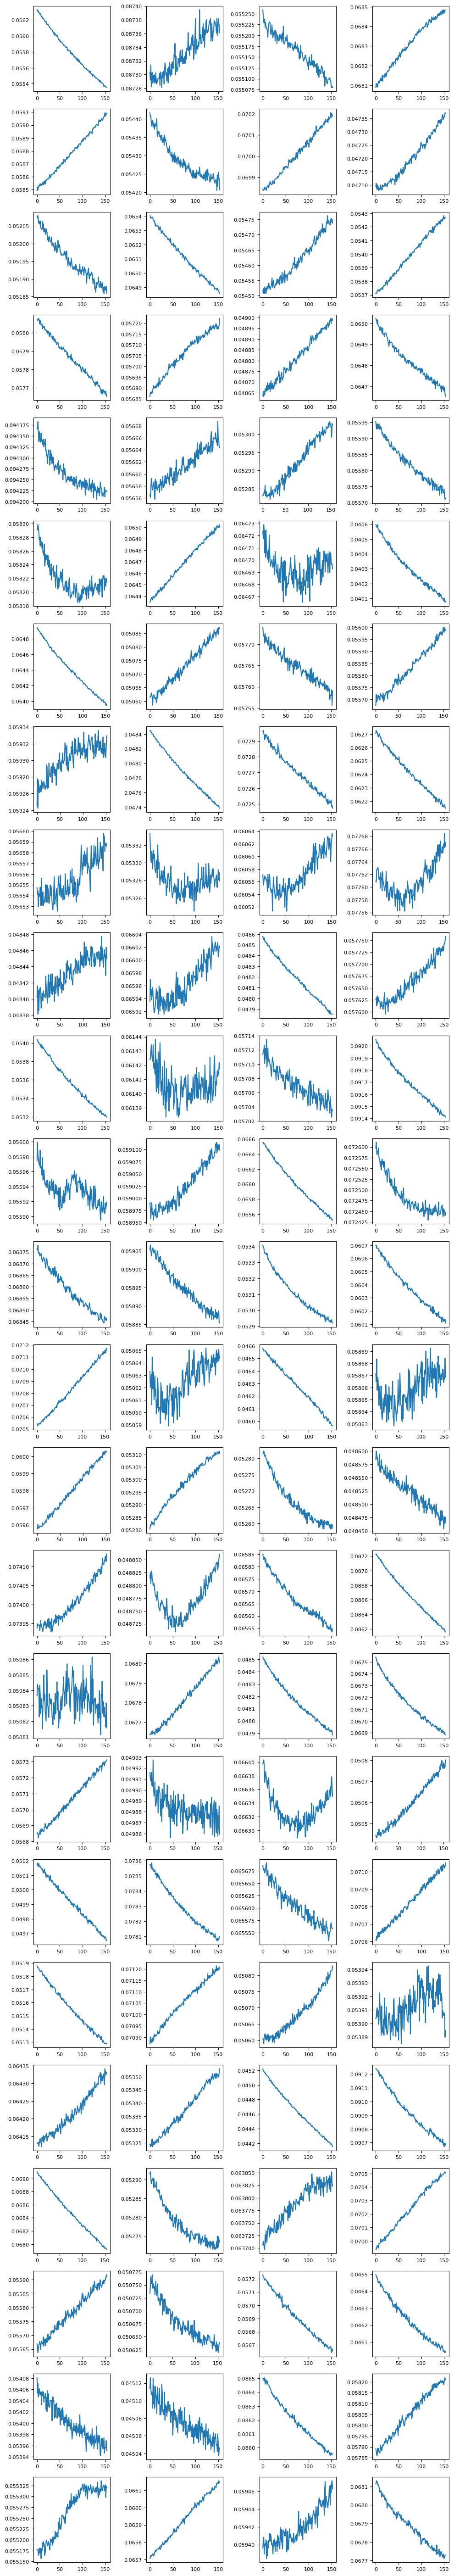

In [12]:
### plot for sanity check
i = 0
j = 100

# calculate grid dimensions
n_plots = len(n_tests[i:j])
n_cols = 4
n_rows = int(np.ceil(n_plots/n_cols))

# create the figure and subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

# flatten the subplots array to make it easier to index
axs = axs.ravel()

# loop over the plots and generate them
for idx, test in enumerate(n_tests[i:j]):
    axs[idx].plot(test.P4)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)

# hide any unused subplots
for i in range(n_plots, n_rows*n_cols):
    axs[i].axis('off')

# show the plots
plt.tight_layout()
plt.show()

In [7]:
def flag_peaks(tests):
    test_peaks = []

    for test in tests:
        # captures ref failures at end of signal
        # note: width=(100, 1400) also optimizes accuracy with 99.4% and 98.5%
        peaks, _ = find_peaks(-1*np.array(test.P4), width=100)
        
        #""""
        if len(peaks) == 0:
            # check for ref failure at start of signal
            peaks, _ = find_peaks(np.array(test.P4), width=100) 
        # """
        
        # peaks = np.concatenate((peaks_1, peaks_2)) # this might be wrong??? why is it a tuple. but if you look at the plots all the peaks are found

        test_peaks.append(peaks)
        
    return test_peaks

In [9]:
### finding peaks in normal tests
n_peaks = flag_peaks(n_tests)

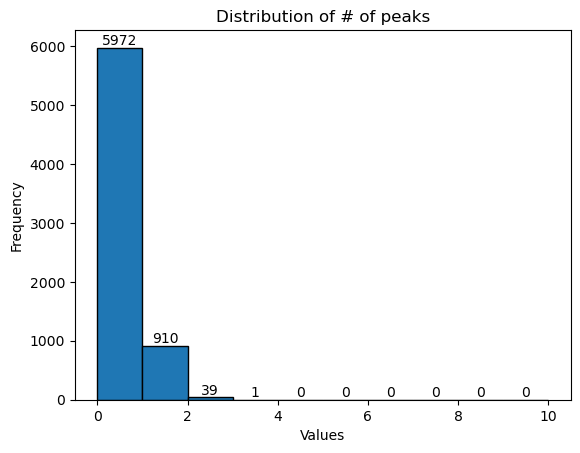

In [15]:
# checking distribution of # of peaks
len_peaks = [len(peaks) for peaks in n_peaks]

bin_edges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# plotting distribution of std
counts, edges, bars = plt.hist(len_peaks, bins=bin_edges, edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.bar_label(bars)
plt.title('Distribution of # of peaks')

# show the plot
plt.show()

In [10]:
len_peaks.sort()
print(len_peaks)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 

In [11]:
print(len(n_peaks))

6922


In [12]:
# investigating normal tests w/ peaks
print(len(n_tests))
print(len(n_peaks))

nonempty_peak_lists = []
for idx, peak_list in enumerate(n_peaks):
    if len(peak_list) != 0:
        nonempty_peak_lists.append(idx)
        
print(len(nonempty_peak_lists))

6922
6922
950


In [13]:
# removing mislabelled tests
n_tests_mislabelled = [7, 34, 74, 135, 191, 202, 275, 337, 507, 530, 560, 582, 646, 659, 661, 665, 669, 886, 906, 968, 1016, 1029, 1102, 1109, 1146, 1148, 1166, 1192, 1206, 1242, 1369, 1387, 1388, 1389, 1390, 1426, 1466, 1487, 1500, 1510, 1513, 1667, 1684, 1687, 1706]

# wait this doesn't even work it should be if idx not in n_tests_mislabelled...
# good thing this was only for my own investigation...
nonempty_peak_lists = [peak_list for peak_list in nonempty_peak_lists if peak_list not in n_tests_mislabelled]
print(nonempty_peak_lists)

[52, 63, 64, 70, 71, 77, 82, 90, 91, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 138, 139, 140, 146, 155, 161, 162, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 192, 193, 195, 196, 197, 198, 200, 201, 204, 205, 206, 207, 208, 211, 212, 213, 214, 216, 217, 218, 222, 271, 298, 307, 334, 345, 350, 364, 385, 419, 420, 435, 460, 473, 511, 521, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 553, 556, 557, 558, 561, 563, 565, 566, 567, 568, 569, 574, 577, 579, 580, 581, 583, 584, 585, 586, 587, 589, 590, 591, 593, 594, 595, 596, 597, 599, 601, 602, 603, 604, 605, 606, 607, 608, 619, 620, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 686, 709, 718, 739, 772, 837, 838, 839, 840, 841, 851, 852, 853, 872, 882, 892, 895, 900, 901, 902, 904, 912,

In [21]:
def plot_waveforms(target_indices, tests, test_peaks, channel):
    n_plots = len(target_indices)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for axs_num, idx in enumerate(target_indices):
        waveform = np.array(getattr(tests[idx], channel))
        peaks = test_peaks[idx]
        
        # plotting waveforms with peaks
        axs[axs_num].plot(waveform)
        axs[axs_num].plot(peaks, waveform[peaks], "x")
        axs[axs_num].tick_params(axis='both', which='major', labelsize=8)

    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()
    
def plot_channel_diff(target_indices, tests):
    n_plots = len(target_indices)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for axs_num, idx in enumerate(target_indices):
        P4_array = np.array(tests[idx].P4)
        P5_array = np.array(tests[idx].P5)
        channel_diff = [x - y for x, y in zip(P4_array, P5_array)]
        
        # plotting waveforms with peaks
        axs[axs_num].plot(channel_diff)
        axs[axs_num].tick_params(axis='both', which='major', labelsize=8)

    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()
    
def compute_noise(target_indices, tests):
    std = []
    
    for idx in target_indices:
        P4_array = np.array(tests[idx].P4)
        P5_array = np.array(tests[idx].P5)
        channel_diff = [x - y for x, y in zip(P4_array, P5_array)]
        
        std.append(np.std(channel_diff))
    
    return std

In [20]:
# simulating pipeline filtering for normal vs ref failure classification
target_lists_1 = []
for idx, peak_list in enumerate(n_peaks):
    if (0 < len(peak_list) <= 5) and (idx not in n_tests_mislabelled):
        target_lists_1.append(idx)

In [57]:
target_lists_2 = []
for idx, peak_list in enumerate(n_peaks):
    if idx not in target_lists_1 and len(peak_list) == 0:
        target_lists_2.append(idx)

In [21]:
print(len(target_lists_1))

1321


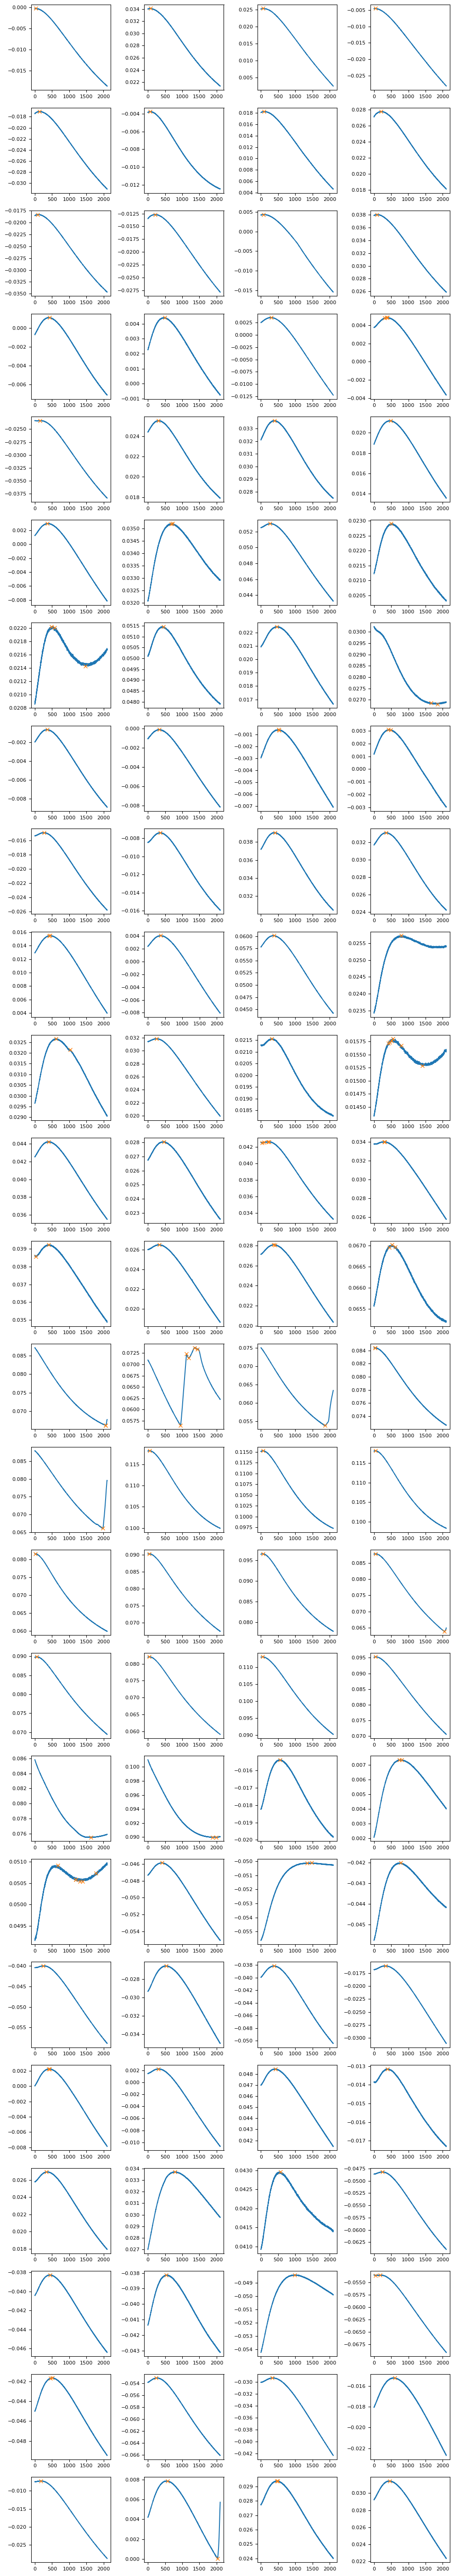

In [23]:
"""# plotting tests of interest with peaks
i = 500
j = 600

target_indices = list(range(len(n_tests[i:j]))) # all
plot_waveforms(nonempty_peak_lists[:100], n_tests, n_peaks, "P4")"""

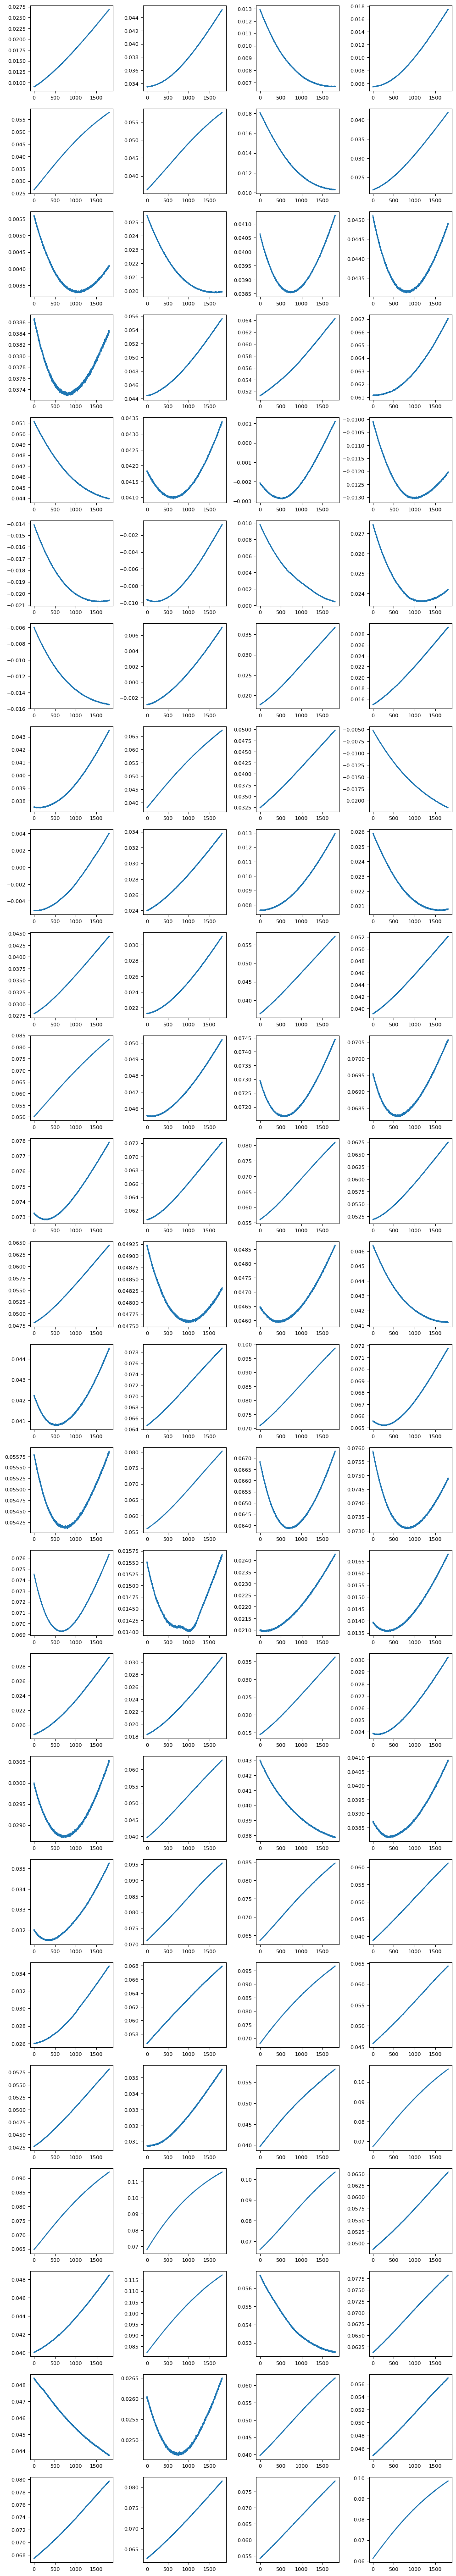

In [43]:
"""# plotting differences between channel waveforms
plot_channel_diff(target_indices, n_tests[i:j])"""

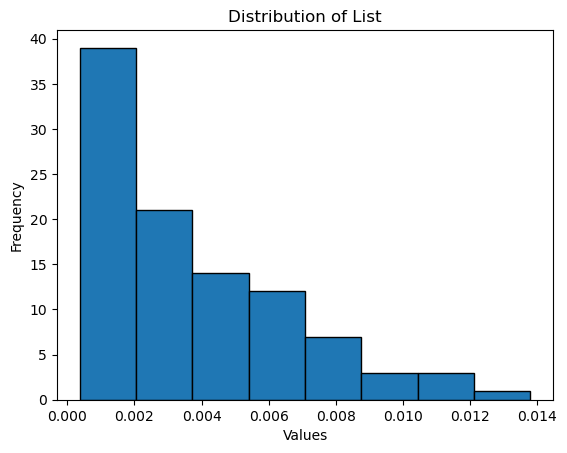

In [51]:
"""# evaluating noisiness of channel difference signals
std = compute_noise(target_indices, n_tests[i:j])

# plotting distribution of std
plt.hist(std, bins='auto', edgecolor='black')

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of List')

# show the plot
plt.show()"""

In [13]:
"""
# grabbing indices of mislabelled tests
sub_idx = [12, 18, 61, 77]
sub_idx = [idx-1 for idx in sub_idx]

mislabelled_idx = []
for idx in sub_idx:
    mislabelled_idx.append(rb_pass_idx[idx])
    
print(mislabelled_idx)

for idx in mislabelled_idx:
    print(rb_tests[idx].ID)
"""

[24, 34, 112, 137]
9976872
10017528
10413109
10834433


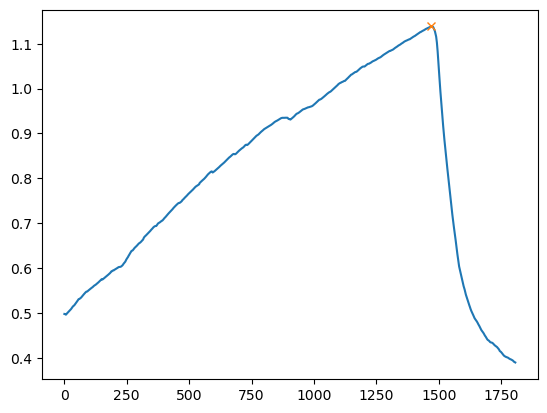

[1468]
1
[1468]
1


In [40]:
"""
# investigating individual samples
test_idx = 6
sample = rb_tests[test_idx]
    
# check for peaks and/or valleys
P4_array = np.array(sample.P4)
peaks = rb_peaks[test_idx]
plt.plot(P4_array)
plt.plot(peaks, P4_array[peaks], "x")
plt.show()

print(peaks)
print(len(peaks))

print(rb_peaks[test_idx])
print(len(rb_peaks[test_idx]))
"""

In [16]:
# define the polynomial function to fit
def poly_func(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


# fit error to polynomial curve
def fit_poly(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(poly_func, x, y)
    y_fit = poly_func(x, *popt) # unpacks tuple into the 6 coefficients rather than passing an array

    return x, y, y_fit, popt # ADDED POPT TO SEE COEFFICIENTS


# define the linear function to fit
def lin_func(x, a, b):
    return a*x + b


# fit data to linear curve for one test
def fit_lin(idx, tests):
    y = tests[idx].P4

    start_time = 0.2
    end_time = 0.2*len(y)
    num_steps = round((end_time - start_time)/0.2) + 1

    x = np.linspace(start_time, end_time, num_steps)

    # perform the curve fit
    popt, _ = curve_fit(lin_func, x, y)
    y_fit = lin_func(x, *popt) # unpacks tuple into the 2 coefficients rather than passing an array

    return x, y, y_fit, popt


def plot_fit(x_list, y_list, y_fit_list):
    n_plots = len(x_list)
    
    # calculate grid dimensions
    n_cols = 4
    n_rows = int(np.ceil(n_plots/n_cols))
    
    # create the figure and subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.25*n_rows))

    # flatten the subplots array to make it easier to index
    axs = axs.ravel()
    
    # loop over the plots and generate them
    for idx, (x, y, y_fit) in enumerate(zip(x_list, y_list, y_fit_list)):
        axs[idx].scatter(x, y, marker='o', s=0.05, label='Data')
        axs[idx].plot(x, y_fit, color='red', label='Fit')
        axs[idx].tick_params(axis='both', which='major', labelsize=8)
        
    # hide any unused subplots
    for i in range(n_plots, n_rows*n_cols):
        axs[i].axis('off')

    # show the plots
    plt.tight_layout()
    plt.show()
    
    
def compute_residuals(y, y_fit):
    residuals = y - y_fit
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
        
    return r_squared

In [9]:
### simulating pipeline filtering for normal vs ref failure classification
print(len(n_tests))
mislabelled_IDs = [9938538,10156680,9925364,9925365,9925366,9925372,9930007,9936122,9938269,9938374,9940434,9940579,9948565,
                   9948808,9976467,9979141,9990178,9990296,9938596,9987550,10016424,10017306,10017317,10018494,10018535,10018609,
                   10019934,10020102,10020118,10032447,10037336,10037557,10045983,10050257,10052220,10053192,10053197,10055126,
                   10055522,10092143,10093215,10093219,10093244,10099978,10099988,10141397,10141399,10144297,10156758,10161679,
                   10161848,10162232,10209158,10209160,10209340,10209347,10209351,10209615,10210158,10210166,10212789,10212816,
                   10216677,10216792,10216948,10217218,10217373,10222336,10222367,10230372,10230503,10230647,10230736,10230861,
                   10231582,10235570,10300110,10300128,10300436,10303517,10324466,10324863,10326050,10326154,10331129,10331645,
                   10331649,10331655,10331682,10351954,10352005,10353310,10353757,10353844,10366986,10367003,10367312,10367314,
                   10368483,10368573,10368599,10371167,10393545,10393678,10393679,10393684,10393688,10398049,10399520,10399548,
                   10399592,10399603,10399606,10444796,10444826,10444850,10445377,10445390,10445467,10447550,10447578,10450845,
                   10473452,10473483,10473498,10474543,10474550,10474802,10477552,10477668,10477673,10477844,10477883,10477893,
                   10479485,10479621,10516528,10516801,10517397,10517537,10521862,10521874,10522228,10522324,10538397,10539869,
                   10540000,10540011,10543357,10543456,10545373,10566923,10566988,10570600,10572212,10572235,10572578,10572595,
                   10612613,10612786,10616681,10617184,10619471,10619563,10084427,10318971,10345699,10156868,10318959,10345692,
                   10637720,10639340,10639356,10639375,10658664,10658673,10658679,10658695,10658707,10661264,10661379,10679756,
                   10682362,10682367,10682785,10730144,10731308,10744370,10744443,10744533,10744534,10751336,10766517]

# cleaning up
to_remove = []
for _, test in enumerate(n_tests):
    # relabelling mislabelled tests
    if test.ID in mislabelled_IDs:
        to_remove.append(test)
        
n_tests = [test for test in n_tests if test not in to_remove]
print(len(n_tests))

# finding peaks in ref failures
n_peaks = flag_peaks(n_tests)

targets = []
for idx, peak_list in enumerate(n_peaks):
    if (0 < len(peak_list) <= 5):
        targets.append(idx)
        
print(len(targets))

6922
6762
1174


In [22]:
### fitting normal tests to polynomial/linear functions
x_list = []
y_list = []
y_fit_list = []
coef_list = []

# splicing
i = 100
j = 200

for idx, _ in enumerate(n_tests):
# for idx in targets:
    x, y, y_fit, coef = fit_poly(idx, n_tests)
    x_list.append(x)
    y_list.append(y)
    y_fit_list.append(y_fit)
    coef_list.append(coef)

In [55]:
### plotting normal tests with fit functions
plot_fit(x_list, y_list, y_fit_list)

KeyboardInterrupt: 

ValueError: Image size of 1000x66150 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x66150 with 75 Axes>

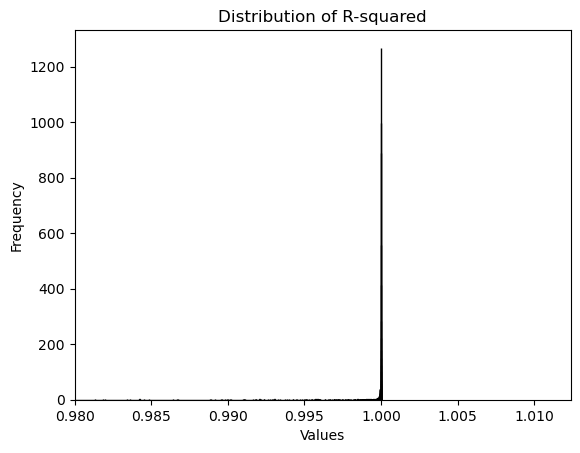

In [25]:
### computing R-squared values to evaluate fit
rs_list = []

for y, y_fit in zip(y_list, y_fit_list):
    rs_list.append(compute_residuals(y, y_fit))
    
rs_list.sort() # DO NOT SORT ON FIRST RUN

"""for r_squared in rs_list:
    print(f"R-squared: {r_squared:.4f}")"""

# plotting distribution of R-squared
plt.hist(rs_list, bins='auto', edgecolor='black')

# set x-axis limits to show only bins above 0.90
plt.xlim(0.98, plt.xlim()[1])  # Keep the current upper limit, set lower limit to 0.90

# add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of R-squared')

# show the plot
plt.show()

In [72]:
# for comparing to ref bubbles
rs_to_remove = []
print(len(rs_list))

for idx, coef in enumerate(coef_list):
    if coef[0] < 0:
        rs_to_remove.append(rs_list[idx])
        
rs_list = [rs for rs in rs_list if rs not in rs_to_remove]
print(len(rs_list))

1174
49


In [84]:
# removing tests that fall in ambiguous region
rs_to_remove = []
print(len(rs_list))

for rs in rs_list:
    if rs <= 0.9982:
        rs_to_remove.append(rs)
        
rs_list = [rs for rs in rs_list if rs not in rs_to_remove]
print(len(rs_list))

1174
1140


In [85]:
limit = []
for rs in rs_list:
    if rs > 0.9975:
        limit.append(rs)
        
print(len(limit))

1140


In [75]:
limit.sort()
print(limit)

[0.9535825024860137, 0.953781788968413, 0.9538461300356136, 0.9545741409828438, 0.9601517097849211, 0.9654617160085031, 0.9662945720932892, 0.9690015675477746, 0.9692770911859634, 0.9784459215589179, 0.9786535313077672, 0.9788923420662189, 0.9813891751373676, 0.9854156659385211, 0.9900590892435368, 0.9920547687361154, 0.9920738312286519, 0.9928406087911873, 0.9942579673977564, 0.9952740102341702]


In [77]:
print(np.mean(rs_list))
print(np.median(rs_list))

0.8220594836940194
0.9085117634090983


In [66]:
# calculating median absolute deviation
median = np.median(rs_list)
MAD = np.median(np.abs(rs_list - median))
print(MAD)

0.07287741172826923


In [79]:
# for samples failing the threshold, how far are they from median R-squared?
# and how close are they to the threshold?
median = np.median(rs_list)
dist_med = []
# dist_threshold = []
for rs in rs_list:
    if rs > 0.9500:
        dist_med.append(rs - median)
        # dist_threshold.append(0.9975 - rs)

# mean_deviation = np.mean(deviations)
# print(mean_deviation)

median_dist_med = np.median(dist_med)
print(median_dist_med)

# median_dist_threshold = np.median(dist_threshold)
# print(median_dist_threshold)

0.0700379630242442
